In [1]:
# Import modules
import os
import sys
sys.path.append(r'..\Hardware_src') # Make the change according to your path

# Python modules for figure visualization
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import io
from scipy import signal
import math
import cv2
import screeninfo
from scipy.linalg import hadamard    


In [27]:
from camera import Camera
import thorlabs_apt as apt
from Stage import  LinearStage

# Instantiate Camera and Linear Stage
c = Camera()
c.open()
c.initialize_memory()

myLinearStage = LinearStage(apt)

Load uc480 library..
ThorCam opened successfully.


In [39]:
# Aperture f/1.6, focus 0.2
# Set the pixel clock
c.set_pixel_clock(7)

# Set exposure - 
c.set_exposure(10)

# # Set the imaging ROI (in raw measurement view)
roi_shape = [1280,1024] # ROI size MUST BE MULTIPLE OF 4
roi_pos = [0,0] # The location of top-left corner of AOI on axis 0 and 1;
                     # Full size is (1280,1024)
c.set_roi(roi_shape, roi_pos)

In [31]:
# Get stage info
myLinearStage.get_properties()

# Get stage to home position
myLinearStage.home()

# Set desired acceleration and velocity
accn = 1000
vel = 150
myLinearStage.set_velocity(accn, vel)

Serial Number 	 67864625
Position Range 	 [0.0, 100.0]  mm
Unit 	 mm
Maximum allowed acceleration 	 7937.3427734375
Maximum allowed velocity 	 697.265625


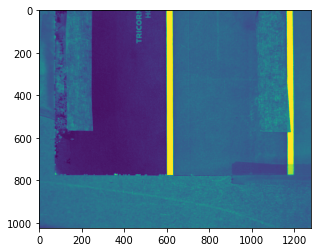

In [7]:
myLinearStage.move_to(40)
img = c.capture().copy()
plt.imshow(img)

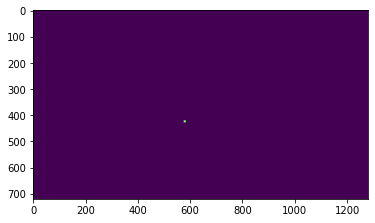

In [44]:
N = 16 # dimensions of reconstruction (pixel height/width)
M = N**2 # number of single pixel images
screen = screeninfo.get_monitors()[1]
width, height = screen.width, screen.height
black = np.zeros((height,width))
pattern = np.zeros((height,width,M))

#%% Generate measurement patterns using a Hadamard matrix. 
## Each row is a 2D pattern (after reshaping)
# H = hadamard(px**2)   # Complete Hadamard matrix (+1s and -1s)

# Generate speckle patterns
specks = np.zeros((N,N,16))
for i in range(16):
#     speck = np.random.normal(0, 1, size=(N, N))
#     speck[speck>0.5] = 1
#     speck[speck<=0.5] = 0
    speck = np.zeros((N,N))
    speck[8,i] = 1
    speck_up = np.repeat(speck, 8, axis=1).repeat(8, axis=0)
    specks[:,:,i] = np.copy(speck)
    pattern[int(height/2-M/2+50+64+10):int(height/2+M/2+50-64+10),int(width/2-M/2+64):int(width/2+M/2-64),i] = np.copy(speck_up)

plt.imshow(pattern[:,:,0])

In [18]:
c.set_framerate(17)

image = pattern[:,:,0]
image[0, 0] = 0  # top-left corner
image[height - 2, 0] = 0  # bottom-left
image[0, width - 2] = 0  # top-right
image[height - 2, width - 2] = 0  # bottom-right

window_name = 'projector'
cv2.namedWindow(window_name, cv2.WND_PROP_FULLSCREEN)
cv2.moveWindow(window_name, screen.x - 1, screen.y - 1)
cv2.setWindowProperty(window_name, cv2.WND_PROP_FULLSCREEN,
                      cv2.WINDOW_FULLSCREEN)
cv2.imshow(window_name, image)

# c.live_image()

cv2.waitKey(20000)  #50000

cv2.destroyWindow(window_name)

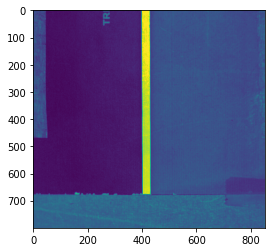

In [29]:

roi_shape = [852,800] # ROI size MUST BE MULTIPLE OF 4
roi_pos = [200,100] # The location of top-left corner of AOI on axis 0 and 1;
                     # Full size is (1280,1024)
c.set_roi(roi_shape, roi_pos)
img = c.capture().copy()

# imgc = img[100:900,200:1050]
plt.imshow(img)

In [36]:
i

23

In [46]:
# TEST CUBE
myLinearStage.move_to(40)
scene = np.zeros((1024,1280,16))
black_subtract = np.zeros((1024,1280,16))
# scene = np.zeros((M))
# black_subtract = np.zeros((M))

# Create image and display on projector
for i in range(16):
    # Display speckle image
    image = pattern[:,:,i]
    image[0, 0] = 0  # top-left corner
    image[height - 2, 0] = 0  # bottom-left
    image[0, width - 2] = 0  # top-right
    image[height - 2, width - 2] = 0  # bottom-right

    window_name = 'projector'
    cv2.namedWindow(window_name, cv2.WND_PROP_FULLSCREEN)
    cv2.moveWindow(window_name, screen.x - 1, screen.y - 1)
    cv2.setWindowProperty(window_name, cv2.WND_PROP_FULLSCREEN,
                          cv2.WINDOW_FULLSCREEN)
    cv2.imshow(window_name, image)
        
    cv2.waitKey(500)
    
    # Take picture of object w/ speckle pattern
    scene[:,:,i] = c.capture().copy()
#     scene[i] = np.mean(c.capture().copy())
    
    cv2.destroyWindow(window_name)
    
    # Display black image
    image = black[:,:]
    image[0, 0] = 0  # top-left corner
    image[height - 2, 0] = 0  # bottom-left
    image[0, width - 2] = 0  # top-right
    image[height - 2, width - 2] = 0  # bottom-right

    window_name = 'projector'
    cv2.namedWindow(window_name, cv2.WND_PROP_FULLSCREEN)
    cv2.moveWindow(window_name, screen.x - 1, screen.y - 1)
    cv2.setWindowProperty(window_name, cv2.WND_PROP_FULLSCREEN,
                          cv2.WINDOW_FULLSCREEN)
    cv2.imshow(window_name, image)
        
    cv2.waitKey(500)
    
    # Take picture of object w/ black projection
    black_subtract[:,:,i] = c.capture().copy()
#     black_subtract[i] = np.mean(c.capture().copy())
    
    cv2.destroyWindow(window_name)
    print(i)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [ ]:
# Subtract "black" image

Y = np.zeros((M))
scene_pix = np.zeros((M))
black_subtract_pix = np.zeros((M))
for i in range(M):
#     scene_pix[i] = np.mean(scene[:,:,i])
#     black_subtract_pix[i] = np.mean(black_subtract[:,:,i])
    Y[i] = scene[i] - black_subtract[i]
    

In [ ]:
Y = Y.reshape(M,1)
C = np.zeros((M,M))
for i in range(M):
    C[i,:] = specks[:,:,i].copy().flatten()
#     C[i,:] = specks[:,:,i].copy().reshape(1,N*N)
    C_pinv = np.linalg.pinv(C)
    
recovery1 = np.dot(C_pinv, Y)
recovery1 = recovery1.reshape(N,N)
plt.imshow(recovery1, cmap='gray')
plt.colorbar()

In [ ]:
np.savetxt('recovery1.csv',recovery.reshape(16,16),delimiter=',')
np.savetxt('speckles1.csv',specks.reshape(16,4096),delimiter=',')
np.savetxt('scene1.csv',scene,delimiter=',')
np.savetxt('black_subtract1.csv',black_subtract,delimiter=',')

In [ ]:
# scene = np.loadtxt('scene1.csv',delimiter=',')
np.savetxt('recovery_fixed1.csv',recovery.reshape(16,16),delimiter=',')
# np.savetxt('black_subtract_fixed.csv',black_subtract,delimiter=',')
#recovery_fixed is with flatten function, recovery_fixed1 is with reshape function

In [49]:
np.savetxt('scene_1d.csv',scene.reshape(1024,20480),delimiter=',')
np.savetxt('black_subtract_1d.csv',black_subtract.reshape(1024,20480),delimiter=',')
np.savetxt('mask_1d.csv',specks.reshape(16,256),delimiter=',')

In [48]:
16*1280

20480

In [52]:
blackimg = np.zeros((height,width))
window_name = 'projector'
cv2.namedWindow(window_name, cv2.WND_PROP_FULLSCREEN)
cv2.moveWindow(window_name, screen.x - 1, screen.y - 1)
cv2.setWindowProperty(window_name, cv2.WND_PROP_FULLSCREEN,
                      cv2.WINDOW_FULLSCREEN)
cv2.imshow(window_name, blackimg)

cv2.waitKey(500)
blackimg = c.capture().copy()
cv2.destroyWindow(window_name)

np.savetxt('blackimg.csv',blackimg,delimiter=',')

In [ ]:
1280*16

In [ ]:
recovery.sum(axis=)

In [ ]:
plt.imshow(specks[:,:,0], cmap='gray')
plt.colorbar()

In [ ]:
# for i in range(5):
plt.imshow(C, cmap='gray')
plt.show()
plt.imshow(C_pinv, cmap='gray')
plt.show()

In [ ]:
# TEST TEST TEST
# get the size of the screen
screen = screeninfo.get_monitors()[1]
width, height = screen.width, screen.height

head = np.zeros((1024,1280))
head1 = np.zeros((1024,1280,10))
head2 = np.zeros((1024,1280,10))
head3 = np.zeros((1024,1280,10))
position = np.array([30,50,70])

# Create image and display on projector
for i in range(5):
    image = imgs[:,:,i]
    image[0, 0] = 0  # top-left corner
    image[height - 2, 0] = 0  # bottom-left
    image[0, width - 2] = 0  # top-right
    image[height - 2, width - 2] = 0  # bottom-right

    window_name = 'projector'
    cv2.namedWindow(window_name, cv2.WND_PROP_FULLSCREEN)
    cv2.moveWindow(window_name, screen.x - 1, screen.y - 1)
    cv2.setWindowProperty(window_name, cv2.WND_PROP_FULLSCREEN,
                          cv2.WINDOW_FULLSCREEN)
    cv2.imshow(window_name, image)
        
    cv2.waitKey(500)
    
    for j in position:
        myLinearStage.move_to(j)
        # Take picture of object w/ speckle pattern
        head[:,:] = c.capture().copy()
        if j == position[0]:
            head1[:,:,i] = head.copy()
        elif j == position[1]:
            head2[:,:,i] = head.copy()
        else:
            head3[:,:,i] = head.copy()
    
    cv2.destroyWindow(window_name)
    

In [ ]:
specks.shape

In [ ]:
black_subtract.shape

In [ ]:
myLinearStage.move_to(50)
head = c.capture().copy()

plt.imshow(head, cmap = 'gray')
plt.colorbar()

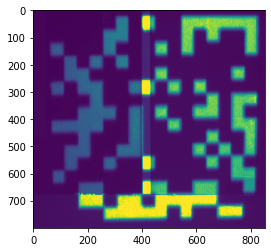

In [32]:
# Display speckle image
myLinearStage.move_to(40)
image = pattern[:,:,i]
image[0, 0] = 0  # top-left corner
image[height - 2, 0] = 0  # bottom-left
image[0, width - 2] = 0  # top-right
image[height - 2, width - 2] = 0  # bottom-right

window_name = 'projector'
cv2.namedWindow(window_name, cv2.WND_PROP_FULLSCREEN)
cv2.moveWindow(window_name, screen.x - 1, screen.y - 1)
cv2.setWindowProperty(window_name, cv2.WND_PROP_FULLSCREEN,
                      cv2.WINDOW_FULLSCREEN)
cv2.imshow(window_name, image)

cv2.waitKey(500)

# Take picture of object w/ speckle pattern
#     scene[:,:,i] = c.capture().copy()
img = c.capture().copy()
# c.live_image()

cv2.destroyWindow(window_name)

plt.imshow(img)

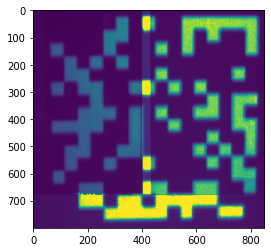

In [14]:
imgc = img[100:900,200:1050]
plt.imshow(imgc)

In [ ]:
head_mean = np.zeros((1024,720))
for i in range(1024):
    for j in range(720):
        head_mean[i,j] = head[i,j,:].mean()
        

plt.imshow(head_mean, cmap = 'gray')
plt.colorbar()

In [ ]:
myLinearStage.move_to(20)
c.live_image()

In [17]:
c.close()

ThorCam closed successfully.
